In [0]:
!wget https://www.dropbox.com/sh/2idnozs4741hzkr/AABXTlPlU-1f4L_VdS4wY06ca?dl=0

In [0]:
!unzip AABXTlPlU-1f4L_VdS4wY06ca?dl=0

In [0]:
!ls 

In [0]:
import os, shutil
folders = os.listdir("images")

In [0]:
if not os.path.isdir("val_images"):
    os.mkdir("val_images")
classes = ["dogs","cats","horses","humans"]
!ls

In [0]:
for c in classes:
    p = os.path.join("val_images",c) #val_images/cats
    if not os.path.isdir(p):
        os.mkdir(p)
      
SPLIT = 0.9
for f in os.listdir("images"):
    path = "images/"+f
    imgs = os.listdir(path)
    
    split_size = int(SPLIT*len(imgs))
    files_to_move = imgs[split_size:]
    #print(len(files_to_move))
    #print(files_to_move)
    for img_f in files_to_move:
        src = os.path.join(path,img_f)
        dest = os.path.join("val_images/"+f,img_f)
        shutil.move(src,dest)

In [0]:
print("Training Data")
for f in folders:
    path = "images/"+f
    print(f+ " "+str(len(os.listdir(path))))
   

print("\n Validation Data") 
for f in folders:
    path = "val_images/"+f
    print(f+ " "+str(len(os.listdir(path))))
    

Training Data
humans 162
cats 162
horses 162
dogs 162

 Validation Data
humans 40
cats 40
horses 40
dogs 40


Using TensorFlow backend.


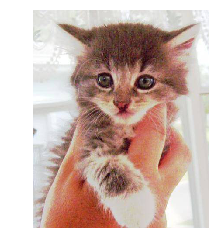

In [0]:
from keras.preprocessing import image
from matplotlib import pyplot as plt

sample_path = "images/cats/cat.100.jpg"
img = image.load_img(sample_path)
x = image.img_to_array(img)/255.0
plt.imshow(img)
plt.axis("off")
plt.show()

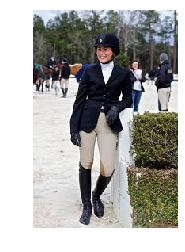

In [0]:
sample_path = "images/humans/rider-103.jpg"
img = image.load_img(sample_path)
x = image.img_to_array(img)/255.0
plt.imshow(img)
plt.axis("off")
plt.show()

In [0]:
from keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(rescale=1.0/255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.3,
    horizontal_flip = True
    )


val_gen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_gen.flow_from_directory(
    "images/",
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'categorical'
)

val_generator = val_gen.flow_from_directory(
    "val_images/",
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'categorical'
)


Found 648 images belonging to 4 classes.
Found 160 images belonging to 4 classes.


In [0]:
for x,y in train_generator:
    print(x.shape)
    print(y.shape)
    break

(32, 224, 224, 3)
(32, 4)


In [0]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

model = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3))
model.summary()





/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [0]:
from keras.layers import * 
from keras.models import Model
av1 = GlobalAveragePooling2D()(model.output)
fc1 = Dense(256,activation='relu')(av1)
d1 = Dropout(0.5)(fc1)
fc2 = Dense(4,activation='softmax')(d1)

model_new = Model(inputs=model.input,output=fc2)

model_new.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


In [0]:
for ix in range(len(model_new.layers)):
    pass
    #print(ix,model_new.layers[ix])

for ix in range(169):
    model_new.layers[ix].trainable = False
    
model_new.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [0]:
# Train our model
from keras.optimizers import Adam
adam = Adam(lr=0.00003)
model_new.compile(optimizer='adam',metrics=['accuracy'],loss='categorical_crossentropy')


In [0]:

history = model_new.fit_generator(
    train_generator,
    epochs = 5,
    steps_per_epoch = 5,
    validation_data = val_generator,
    validation_steps = 4   
)

Epoch 1/5
5/5 [==============================] - 3s 688ms/step - loss: 0.0924 - acc: 0.9562 - val_loss: 2.7280 - val_acc: 0.3047
Epoch 2/5
5/5 [==============================] - 3s 558ms/step - loss: 0.0681 - acc: 0.9586 - val_loss: 3.2347 - val_acc: 0.2422


In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss= history.history['val_loss']


In [0]:
plt.plot(acc,label="accuracy")
plt.plot(val_acc,label="val acc")
plt.plot(loss,label='loss')
plt.plot(val_loss,label='val loss')
plt.legend()
plt.show()